In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.config.list_physical_devices('GPU'))

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
train_dir = '/home/jetcalz07/state_farm_distracted_driver/data/imgs/train/'
test_dir = '/home/jetcalz07/state_farm_distracted_driver/data/imgs/test/'

### Load Data

In [3]:
# Function to read indiv image
def get_cv2_image(path, img_rows, img_cols, color_type=1):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

In [4]:
num_classes = 10
classes = ['c' + str(x) for x in range(num_classes)]

# Load train batch into image and label arrays
def load_train(img_rows, img_cols, color_type=1):
    train_imgs = []
    train_labels = []
    
    # Go through each folder
    i = 0
    for class_ in classes:
        files = glob(os.path.join(train_dir, class_, '*.jpg'))
        for file in tqdm(files):
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_imgs.append(img)
            train_labels.append(i)
        i += 1
            
    return train_imgs, train_labels


# Split into train and val
def normalize_and_split_train_val(img_rows, img_cols, color_type=1):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert dtype and reshape for batches
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_val = np.array(x_val, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_val, y_train, y_val
    
    
# Same for test
def load_test(img_rows, img_cols, color_type=1, size=200000):
    test_data = []
    test_files = []
    
    files = glob(os.path.join(test_dir, '*.jpg'))
    total = 0
    for file in tqdm(files):
        if total >= size:
            break
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        test_data.append(img)
        test_files.append(file)
        total += 1
            
    return test_data, test_files

def read_and_normalize_test_data(img_rows, img_cols, color_type=1, size=200000):
    test_data, test_files = load_test(img_rows, img_cols, color_type, size)
    test_data = np.array(test_data, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_files

100%|█████████████████████████████████████| 2129/2129 [00:07<00:00, 299.69it/s]


X Train shape: (17939, 64, 64, 3)
Y Train shape: (17939, 10)
X Val shape: (4485, 64, 64, 3)
Y Val shape: (4485, 10)

Sample Image Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


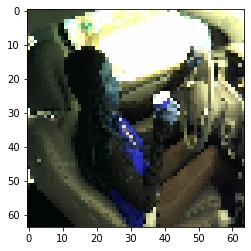

In [5]:
img_rows = 64
img_cols = 64
color_type = 3

x_train, x_val, y_train, y_val = normalize_and_split_train_val(img_rows, img_cols, color_type)
print('X Train shape:', x_train.shape)
print('Y Train shape:', y_train.shape)
print('X Val shape:', x_val.shape)
print('Y Val shape:', y_val.shape)

print(f"\nSample Image Label: {y_train[0]}")
plt.imshow(x_train[0], cmap='gray')

### Model Functions

In [8]:
def build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels):
    inputs = Input(shape=(input_shape))
    
    # Conv + Pool #1
    conv1 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(inputs)
    maxp1 = MaxPooling2D(pool_size)(conv1)
    drop1 = Dropout(dropout)(maxp1)
    
    # Conv + Pool #2
    conv2 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(drop1)
    maxp2 = MaxPooling2D(pool_size)(conv2)
    drop2 = Dropout(dropout)(maxp2)
    
    # Conv + Pool #3
    conv3 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(drop2)
    maxp3 = MaxPooling2D(pool_size)(conv3)
    drop3 = Dropout(dropout)(maxp3)
    
    # Flatten + Dropoout
    flat = Flatten()(drop3)
    drop = Dropout(dropout)(flat)
    
    # Fully Connected
    outputs = Dense(num_labels, activation = 'softmax')(drop)
    
    # Build
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    plt.show()

In [6]:
## Handle Submission
def evaluate_test(model, img_rows, img_cols, color_type, nb_test_samples):
    # Load test data
    x_test, test_files = read_and_normalize_test_data(img_rows, img_cols, color_type, nb_test_samples)
    print('Test shape:', x_test.shape)

    # Create batches to avoid GPU OOM on large test set
    batch_size = 128
    steps = x_test.shape[0] // batch_size
    print(f"# of steps in test: {steps+1}")

    # Predict and save df
    preds_df = pd.DataFrame()
    for step in tqdm(range(steps)):
        if step < (steps-1):
            x_test_batch = x_test[batch_size*step:batch_size*(step+1)]
            test_files_batch = test_files[batch_size*step:batch_size*(step+1)]
        else:
            x_test_batch = x_test[batch_size*step:]
            test_files_batch = test_files[batch_size*step:]
        preds = model.predict_on_batch(x_test_batch)

        # Create df and append to master df
        sub_df = pd.DataFrame(preds)
        sub_df.columns = [f'c{x}' for x in range(10)]
        sub_df['img'] = [os.path.basename(x) for x in test_files_batch]
        cols = sub_df.columns.to_list()
        sub_df = sub_df[cols[-1:] + cols[0:-1]]
        
        preds_df = pd.concat([preds_df, sub_df], axis = 0)
    print(f"Shape Preds: {preds_df.shape}")
        
    return preds_df

### Train Simple CNN + Batch Image Augmentation

In [11]:
size_x = x_train.shape[1]
size_y = x_train.shape[2]
input_shape = (size_x, size_y, color_type)
batch_size = 128
kernel_size = 3
pool_size=(2, 2)
filters = 64
dropout = 0.3
num_labels = 10

In [13]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   rotation_range=20,
                                   horizontal_flip = False)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

val_datagen = ImageDataGenerator(rescale=1.0/ 255)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

cnn_datagen = build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels)
history = cnn_datagen.fit_generator(training_generator,
                                     steps_per_epoch = x_train.shape[0] // batch_size,
                                     epochs = 20, 
                                     verbose = 1,
                                     validation_data = val_generator,
                                     validation_steps = x_val.shape[0] // batch_size)

Epoch 1/20
140/140 [==============================] - 21s 144ms/step - loss: 2.0049 - accuracy: 0.2625 - val_loss: 1.3684 - val_accuracy: 0.5377
Epoch 2/20
140/140 [==============================] - 20s 141ms/step - loss: 1.2321 - accuracy: 0.5753 - val_loss: 0.7102 - val_accuracy: 0.8201
Epoch 3/20
140/140 [==============================] - 22s 154ms/step - loss: 0.8329 - accuracy: 0.7196 - val_loss: 0.4380 - val_accuracy: 0.8949
Epoch 4/20
140/140 [==============================] - 20s 141ms/step - loss: 0.6046 - accuracy: 0.8040 - val_loss: 0.3099 - val_accuracy: 0.9214
Epoch 5/20
140/140 [==============================] - 20s 141ms/step - loss: 0.5051 - accuracy: 0.8392 - val_loss: 0.2291 - val_accuracy: 0.9487
Epoch 6/20
140/140 [==============================] - 20s 145ms/step - loss: 0.4361 - accuracy: 0.8598 - val_loss: 0.2060 - val_accuracy: 0.9473
Epoch 7/20
140/140 [==============================] - 23s 161ms/step - loss: 0.3862 - accuracy: 0.8781 - val_loss: 0.1610 - val_ac

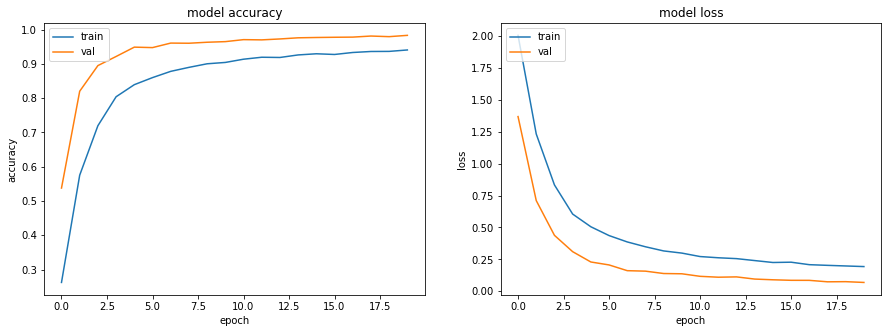

In [14]:
plot_history(history)

### Evaluate and Submit

In [ ]:
try:
    del x_train, x_val, y_train, y_val
except:
    pass

## Evaluate test, save
nb_test_samples = len(os.listdir(test_dir))
img_rows_test = 256
img_cols_test = 256
preds_df = evaluate_test(cnn_datagen, img_rows_test, img_cols_test, color_type, nb_test_samples)
preds_df.to_csv('./test_preds/preds_simple_cnn_batch_aug.csv', index=False)
preds_df.head()

 39%|█████████████▌                     | 30963/79726 [02:14<05:56, 136.70it/s]

In [ ]:
# Submit to kaggle thru CLI
!kaggle competitions submit -c state-farm-distracted-driver-detection -f ./test_preds/preds_simple_cnn_batch_aug.csv -m "aug_submission"

### Code Garage

In [ ]:
# # Same for test
# def load_test_batch(img_rows, img_cols, start, end, color_type=1):
#     test_data = []
#     test_files = []
    
#     files = glob(os.path.join(test_dir, '*.jpg'))
#     total = 0
#     for file in files[start:end]:
#         img = get_cv2_image(file, img_rows, img_cols, color_type)
#         test_data.append(img)
#         test_files.append(file)
#         total += 1
            
#     return test_data, test_files

# def read_reshape_test_batch(img_rows, img_cols, start, end, color_type=1):
#     test_data, test_files = load_test_batch(img_rows, img_cols, start, end, color_type)
#     test_data = np.array(test_data, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
#     return test_data, test_files